# Lognormal ECG Forward Modeling

### Imports


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import heartpy as hp
import seaborn as sns
import mne

from tqdm.notebook import tqdm
from pathlib import Path

from rl import get_segments, process_ecg_data_segment

# Getting ECG segments

In [ ]:
root_edf_path = Path("Create_Segments/all_infants_edf/")

no_log_found = []
original_freqs = []
all_segments = {}
for edf_path in tqdm(list(root_edf_path.glob("*"))):
    subject, age = edf_path.name.replace(".edf", "").split("_")
    res = get_segments(edf_path)
    if res is None:
        no_log_found.append(edf_path.name)
        continue
    
    original_freqs.append(mne.io.read_raw_edf(edf_path).info["sfreq"])
    segments, conditions, sfreq = res
    for segment, condition in zip(segments, conditions): 
        all_segments[(subject, age, condition, sfreq)] = segment

In [5]:
print(f"Number of EDF files: {len(list(root_edf_path.glob('*')))}")
print(f"Number of files with missing time logs: {len(no_log_found)}")

Number of EDF files: 215
Number of files with missing time logs: 69


In [6]:
print("Original sampling frequency:")
for freq, n in zip(*np.unique(original_freqs, return_counts=True)):
    print(f"{freq} Hz: {n}")

Original sampling frequency:
128.0 Hz: 26
512.0 Hz: 13
1024.0 Hz: 107


In [7]:
nb_samples = [len(segment) for segment in all_segments.values()]
durations_df = pd.DataFrame(all_segments.keys(), columns=["subject", "age", "condition", "freq"])
durations_df["duration"] = nb_samples/durations_df.freq

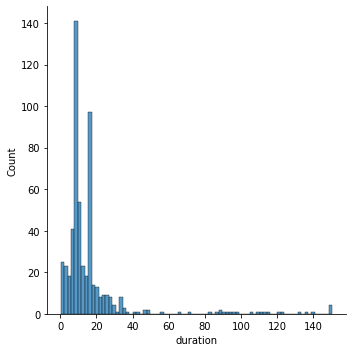

In [8]:
sns.displot(durations_df.duration/60)

In [9]:
np.round(np.percentile(durations_df.duration, [0, 10, 25, 50, 75, 90, 100])/60, 2)

array([  0.25,   4.75,   8.45,  10.22,  16.24,  27.1 , 150.25])

In [10]:
segment_df = pd.DataFrame(all_segments.keys(), columns=["subject", "age", "exp", "freq"])
ages = np.array([age.split("m")[0] for age in segment_df.age]).astype(object)
ages[ages == "1w"] = "0.25"
segment_df["age_num"] = ages.astype(float)
print(f'{segment_df.groupby(["subject", "age_num"]).mean().shape[0]} recordings.')
print(f"{segment_df.subject.unique().shape[0]} subjects.")
print(f"Age range: {segment_df.age_num.min()}-{segment_df.age_num.max()}")
print(f"Number of segments: {segment_df.shape[0]}")
segment_df.groupby(["subject", "age_num"]).mean().reset_index().groupby("age_num").count()["subject"]

143 recordings.
40 subjects.
Age range: 0.25-24.0
Number of segments: 550


age_num
0.25      1
1.00     10
2.00     14
3.00     19
4.00     23
6.00     17
9.00     20
12.00    17
15.00    11
18.00     7
24.00     4
Name: subject, dtype: int64

In [11]:
outputs = []
invalids = []
for segment_key in tqdm(all_segments):
    sfreq = segment_key[-1]
    output = process_ecg_data_segment(all_segments[segment_key], 
                                      sfreq, resample=1024.)
    if output is None or output["SNR"] < 5:
        output2 = process_ecg_data_segment(all_segments[segment_key], 
                                      sfreq, windowsize=0.1, resample=1024.)
        if output2 is None:
            invalids.append(segment_key)
            continue
        if output2["SNR"] >= 5:
            output = output2

    #del output["raw_t"]
    del output["wd"]
    
    output["raw_beats"] = (output["raw_beats"].T - np.median(output["raw_beats"], axis=1)).T
    output["clean_beats"] = (output["clean_beats"].T - np.median(output["clean_beats"], axis=1)).T
    output["subject"], output["age"], output["condition"] = segment_key[:3]
    outputs.append(output)

  0%|          | 0/550 [00:00<?, ?it/s]

/Users/christian/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/christian/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/christian/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [12]:
segment_info_df = pd.DataFrame(outputs)
segment_info_df.sfreq 
segment_info_df["valid_beat_ratio"] = segment_info_df.nb_valid_beats/(segment_info_df.nb_valid_beats + segment_info_df.nb_invalid_beats)

In [13]:
len(invalids), invalids

(5,
 [('1003', '9m', 'DEV1', 1024.0),
  ('1020', '6mAdj', 'DEV2', 1024.0),
  ('1002', '9m', 'DEV4', 1024.0),
  ('1002', '9m', 'DEV5', 1024.0),
  ('1027', '1m', 'DEV4', 1024.0)])

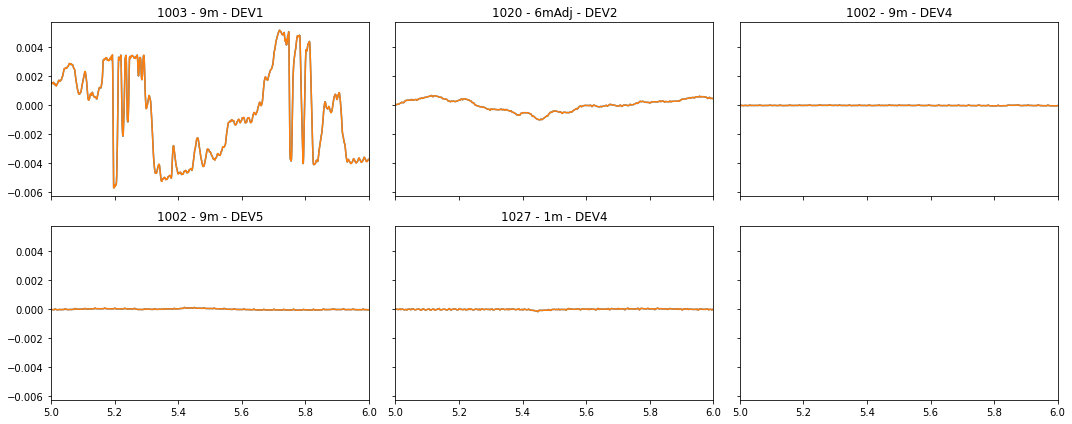

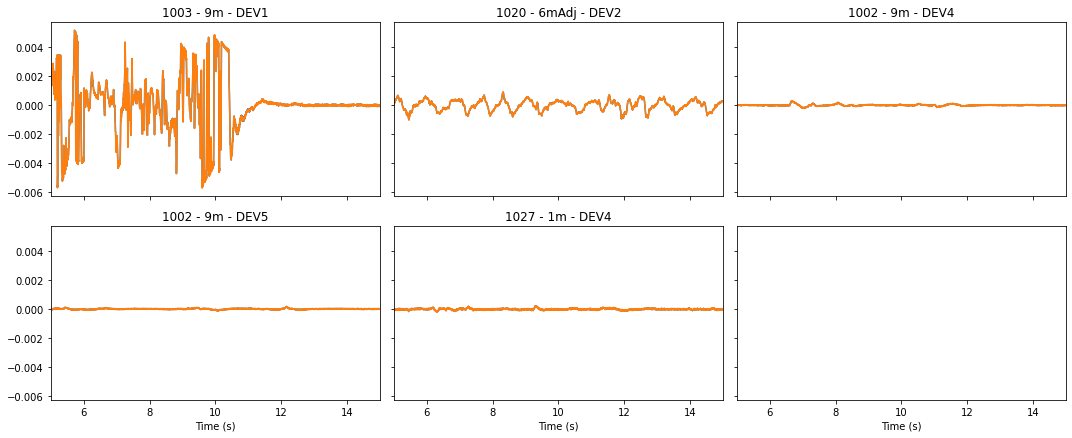

In [14]:
tmin = 5
for tmax in [6, 15]:    
    fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)
    for key, ax in zip(invalids, axes.ravel()):
        t = np.arange(tmin, tmax, 1.0/key[-1])
        
        data = all_segments[key]
        data = data[int(key[-1]*tmin):int(key[-1]*tmax)]
        ax.plot(t, data, label="raw")
        
        data = mne.filter.notch_filter(all_segments[key], key[-1], [60], pad='reflect', verbose=False)
        data = data[int(key[-1]*tmin):int(key[-1]*tmax)]
        t = np.arange(tmin, tmax, 1.0/key[-1])
        ax.plot(t, data, label="notch_filtered")
        
        ax.set_title(" - ".join(key[:3]))
        ax.set_xlim(tmin, tmax)
    fig.tight_layout()
    
for ax in axes[-1]:
    ax.set_xlabel("Time (s)")

<Axes: xlabel='valid_beat_ratio', ylabel='Count'>

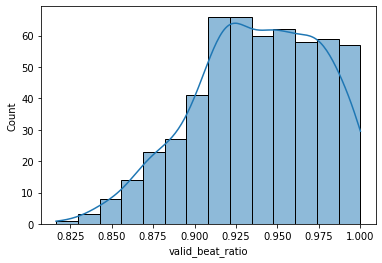

In [15]:
sns.histplot(segment_info_df.valid_beat_ratio, kde=True)

0


<Axes: xlabel='SNR', ylabel='Count'>

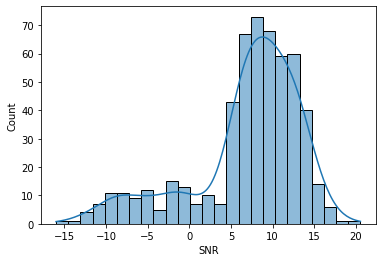

In [16]:
rejected_freq = np.sum(~(segment_info_df.sfreq == 1024.))
print(rejected_freq)

sns.histplot(segment_info_df.SNR, kde=True)

In [17]:
segment_info_df["valid_beat_ratio"] = segment_info_df.nb_valid_beats/(segment_info_df.nb_valid_beats + segment_info_df.nb_invalid_beats)
clean_ecg_recordings = segment_info_df[#(segment_info_df.valid_beat_ratio > .9) & 
                                       (segment_info_df.SNR > 5) &
                                       (segment_info_df.sfreq == 1024.)]

In [18]:
rejected_total = np.sum(~(#(segment_info_df.valid_beat_ratio > .9) & 
                                       (segment_info_df.SNR > 5) &
                                       (segment_info_df.sfreq == 1024.)))
#rejected_valid_ratio = np.sum(~(segment_info_df.valid_beat_ratio > .9))
rejected_snr = np.sum(~(segment_info_df.SNR > 5))
rejected_freq = np.sum(~(segment_info_df.sfreq == 1024.))

#print(f"Number of rejected segments: {rejected_total} (valid ratio: {rejected_valid_ratio};"
#      f" SNR: {rejected_snr}; frequency: {rejected_freq})")

print(f"Number of rejected segments because SNR < 5dB: {rejected_snr}; frequency: {rejected_freq})")


Number of rejected segments because SNR < 5dB: 115; frequency: 0)


In [19]:
print(f"Number of valid segments for analysis: {clean_ecg_recordings.shape[0]}")

Number of valid segments for analysis: 430


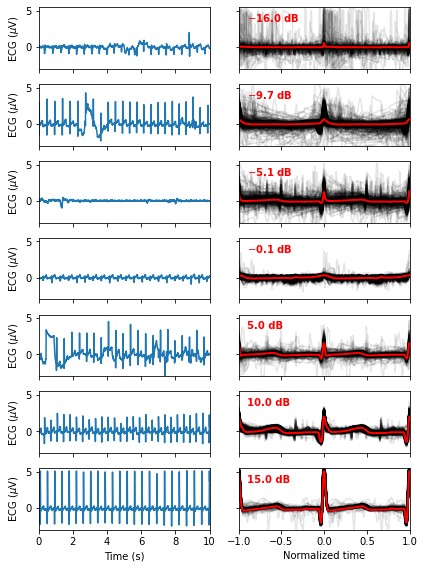

In [20]:
snrs = [-15, -10, -5, 0, 5, 10, 15]
fig, axes = plt.subplots(len(snrs), 2, figsize=(6, 8), sharey=True, sharex="col")

all_segments_no_freq = {key[:-1]: val for key, val in all_segments.items()}

sfreq = 1024.
tmin=0
tmax=10
for ax_row, snr in zip(axes, snrs):

    key = tuple(segment_info_df.loc[np.abs(segment_info_df.SNR - snr).argmin()][["subject", 
                                                                                 "age", 
                                                                                 "condition"]].tolist())
    t = np.arange(tmin, tmax, 1.0/sfreq)
    data = all_segments_no_freq[key][int(sfreq*tmin):int(sfreq*tmax)]
    ax_row[0].plot(t, data*1000, label="raw")    
    
    t = np.arange(-1, 1, 1/250)
    ind = np.abs(segment_info_df.SNR - snr).argmin()
    ax_row[1].plot(t, segment_info_df.loc[ind].clean_beats.T*1000, color="k", alpha=0.1);
    ax_row[1].plot(t, segment_info_df.loc[ind].mean_beat*1000, color="r", linewidth=2);
    ax_row[1].text(-0.9, 3.5, f"{np.round(segment_info_df.loc[ind].SNR, 1)} dB".replace("-", "$-$"), 
                   color="r", weight="bold")
    
ax_row[0].set_xlabel("Time (s)")
ax_row[0].set_xlim(0, 10)
ax_row[1].set_xlabel("Normalized time")
ax_row[1].set_xlim(-1, 1)
    
for ax in axes.T[0]:
    ax.set_ylabel(r"ECG ($\mu$V)")
ax.set_ylim(-3, 5.5)
    
        
fig.tight_layout()
fig.savefig("snr.png")

In [21]:
clean_ecg_recordings["data"] = [all_segments_no_freq[tuple(key)] 
                                for key in clean_ecg_recordings[["subject", "age", "condition"]].values]
clean_ecg_recordings.reset_index(drop=True).to_pickle("clean_ecg_for_RL.pck")

/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_18786/724579870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ecg_recordings["data"] = [all_segments_no_freq[tuple(key)]
